# Определение возраста покупателей

Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1.Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

2.Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [2]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_it = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory='/datasets/faces/final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345) 

Found 7591 validated image filenames.


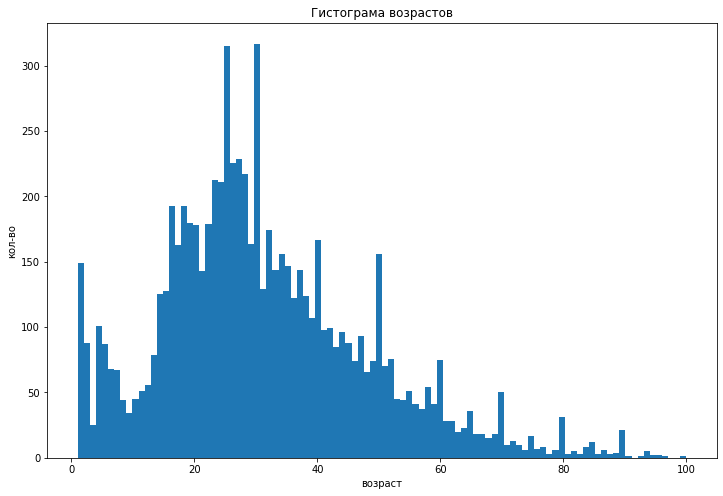

In [19]:
ax = labels.real_age.plot(kind='hist', bins=100, figsize=(12,8),title = 'Гистограма возрастов');
ax.set_xlabel("возраст");
ax.set_ylabel("кол-во");

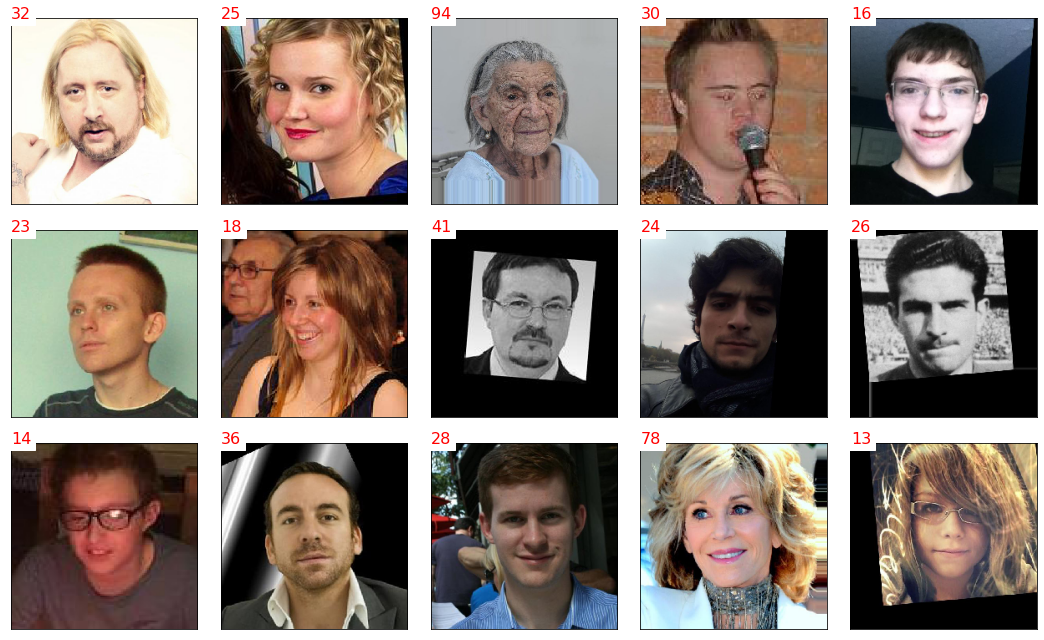

In [10]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    i=i+17
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

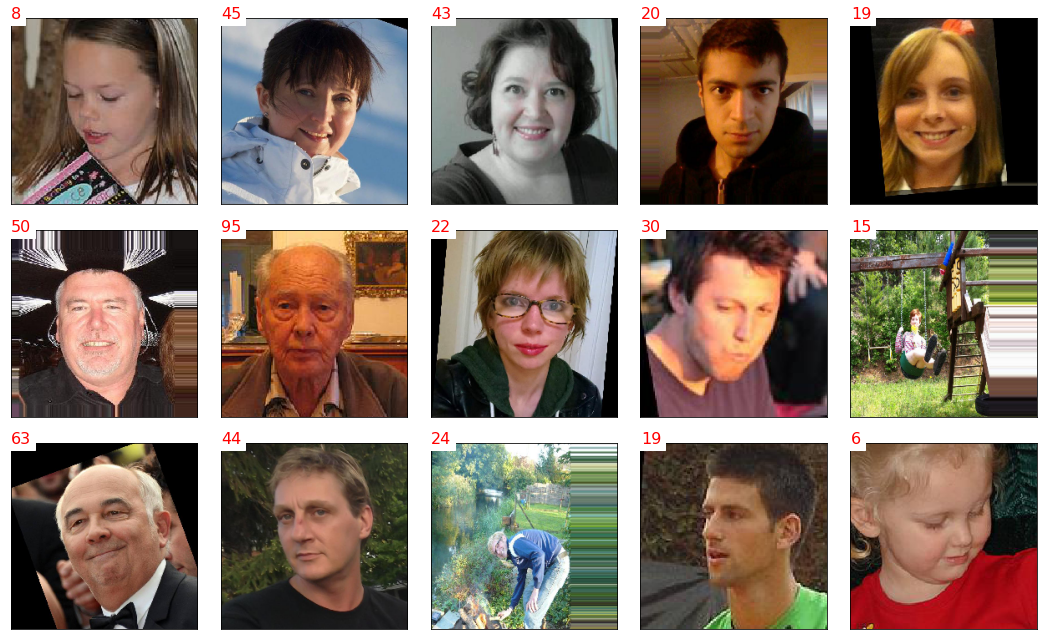

In [14]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    i=i+4
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Был загружен датасет и выявлено, что не все фотографии квадратные и одинакового размера, это может повлиять на результаты обучения. Так же не все фотографии портретные, могут присутствовать постороние предеметы или же фотографии во весь рост.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

optimizer = Adam(lr=0.0001)
 
def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
 
    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):

    backbone = ResNet50(input_shape=(224,224,3),
                    weights='imagenet',
                    include_top=False) 
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,

                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

Train for 356 steps, validate for 119 steps

Epoch 1/5

2023-05-01 17:55:47.601612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

libcublas.so.10

2023-05-01 17:55:48.467161: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library

libcudnn.so.7

356/356 - 67s - loss: 201.5828 - mae: 10.3234 - val_loss: 715.3379 - val_mae: 21.6984

Epoch 2/5

356/356 - 64s - loss: 82.6448 - mae: 6.8996 - val_loss: 352.5503 - val_mae: 15.7725

Epoch 3/5

356/356 - 69s - loss: 57.6557 - mae: 5.7902 - val_loss: 92.4225 - val_mae: 7.3798

Epoch 4/5

356/356 - 48s - loss: 43.9899 - mae: 5.0703 - val_loss: 75.6939 - val_mae: 6.6214

Epoch 5/5

356/356 - 71s - loss: 31.2006 - mae: 4.2593 - val_loss: 83.6764 - val_mae: 6.9030

WARNING:tensorflow:sample_weight modes were coerced from

  ...
    to  
    
  ['...']
  
119/119 - 11s - loss: 83.6764 - mae: 6.9030

Test MAE: 6.9030

## Анализ обученной модели

Модель достигла значения MAE = 6.9 за 5 эпох.

В среднем модель ошибается примерно на 7 лет при предсказании возраста на тестовой выборке и на 4 на тренировочной.

Требуемое значение метрики MAE < 8 получено